### 1. 线性回归

#### （1）矢量化加速

In [1]:
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [2]:
# 向量相加演示

n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [3]:
class Timer: #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start() # 创建对象时开始计时

    def start(self):
        """启动计时器"""
        self.tik = time.time() # 记录开始时间

    def stop(self):
        """停止计时，并把时间记录到列表中"""
        self.times.append(time.time() - self.tik) # 当前时间 - 开始时间
        return self.times[-1]

    def avg(self):
        """记录平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """记录总时间"""
        return sum(self.times)

    def cumsum(self):
        """返回累积时间"""
        return np.array(self.times).cumsum().tolist()
        
    

In [4]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.09102 sec'

In [5]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00017 sec'

#### （2） 正态分布与平方损失

* 正态分布概率密度函数：

  $$ p(x)=\frac{1}{\sqrt{2\pi \sigma^2}}exp(-\frac{1}{2\sigma^2}(x-\mu)^2) $$

In [6]:
def normal(x,mu,sigma):
    p = 1 / math.sqrt(2*math.pi*sigma**2)
    return p * np.exp(-0.5/sigma**2*(x-mu)**2)

* 可视化正态分布

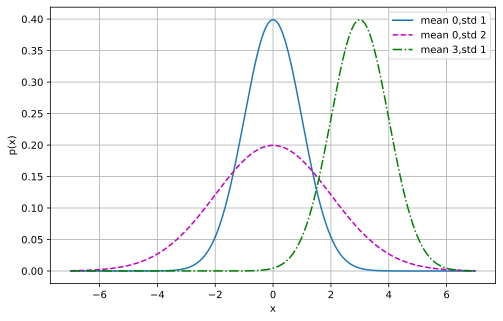

In [7]:
x = np.arange(-7,7,0.01)

# 均值与标准差对
params = [(0,1),(0,2),(3,1)]

d2l.plot(x,[normal(x,mu,sigma) for mu, sigma in params], xlabel='x',ylabel='p(x)', figsize = (8,5),
        legend=[f'mean {mu},std {sigma}' for mu, sigma in params])

#### （3）从零开始实现线性回归

* 导包

In [8]:
import random
import torch
from d2l import torch as d2l

* 人造数据集

In [9]:
# 生成一个包含1000个样本的数据集
# 每个样本包含从标准正态分布中采样的2个特征
# 采用线性模型参数W = [2,-3.4], b = 4.2 和噪声项epsilon来生成数据集
# 噪声项epsilin服从均值为0，标准差为0.01的正态分布

def synthetic_data(w,b,num_examples): #@save
    """生成y = wx + b+ 噪声 """
    X = torch.normal(0,1,(num_examples, len(w)))
    y = torch.matmul(X,w) + b
    y += torch.normal(0,0.01,y.shape)
    return X,y.reshape((-1,1))

In [10]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features, labels = synthetic_data(true_w,true_b,1000)
print('features:',features[0:5],'\n label:',labels[0:5])

features: tensor([[ 0.4762, -2.3136],
        [ 1.0694,  0.2960],
        [ 0.2302,  1.4045],
        [-0.3619, -0.1373],
        [ 0.1083,  0.6332]]) 
 label: tensor([[13.0137],
        [ 5.3234],
        [-0.1252],
        [ 3.9382],
        [ 2.2708]])


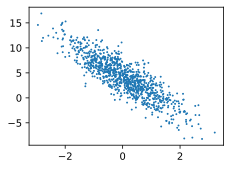

In [11]:
# 绘制散点图，观察线性特征

d2l.set_figsize()
d2l.plt.scatter(features[:,(1)].detach().numpy(),labels.detach().numpy(),1)

* 随机抽取小批量样本

In [12]:
def data_iter(batch_size,features,labels):
    num_examples = len(features) # 总样本个数
    indices = list(range(num_examples)) # 
    # 打乱索引，以保证每个批次的数据都是随机选取的
    random.shuffle(indices) 
    for i in range(0,num_examples,batch_size):
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [13]:
# 读取第一个小批量数据样本并打印
batch_size = 10
for X, y in data_iter(batch_size,features,labels): # 在运行迭代时，会连续获得不同批次的样本，直至遍历完整个数据集
    print(X,'\n',y)
    break

tensor([[ 0.4988, -0.0457],
        [ 0.0135, -0.3133],
        [-1.2277,  0.3066],
        [-1.2388, -0.6616],
        [-0.2432, -0.4950],
        [-1.6571, -0.6394],
        [ 1.3344,  0.9831],
        [ 1.3707,  1.0211],
        [ 1.3985, -0.2168],
        [-0.7709,  0.0703]]) 
 tensor([[5.3559],
        [5.2949],
        [0.7079],
        [3.9760],
        [5.3954],
        [3.0650],
        [3.5144],
        [3.4774],
        [7.7537],
        [2.4247]])


* 初始化模型参数

In [14]:
# 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重
# 偏置初始化为0
# 在初始化参数后，任务变为更新这些参数，每次更新都需要计算损失函数关于模型参数的梯度，手动计算梯度容易出错，所以使用自动微分来计算
w = torch.normal(0,0.01,size=(2,1),requires_grad=True) 
b = torch.zeros(1,requires_grad=True)

* 定义模型

In [15]:
# 将模型输入和参数同模型的输出关联起来
def linreg(X,w,b): #@save
    """线性回归模型"""
    return torch.matmul(X,w) + b

* 定义损失函数

In [16]:
# 使用平方损失函数
def squared_loss(y_hat,y): #@save
    """均方损失"""
    return (y_hat-y.reshape(y_hat.shape))**2/2

* 定义优化算法

In [17]:
# 上述损失计算的是批量样本的总和，需要规范化
def sgd(params, lr, batch_size): #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_() # 梯度重置为0

* 训练

In [18]:
# 设置超参数，迭代周期个数=3，学习率=0.03
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

In [19]:
for epoch in range(num_epochs):
    # 每个迭代周期，会遍历整个数据集完成梯度更新
    for X,y in data_iter(batch_size,features,labels):
        l = loss(net(X,w,b),y) # 小批量损失,是一个向量
        l.sum().backward() # 计算小批量损失和关于w,b的梯度
        sgd([w,b],lr,batch_size) # 更新参数
    with torch.no_grad(): # 临时禁用梯度更新，代码块中所有张量操作不再记录梯度，一般用于模型评估/推理
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.043855
epoch 2, loss 0.000170
epoch 3, loss 0.000050


In [20]:
# 估计误差
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([-0.0009, -0.0011], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0005], grad_fn=<RsubBackward1>)


#### （4）线性回归的简洁实现（使用深度学习框架来实现）

* 生成数据集

In [21]:
import numpy as np
import torch
from d2l import torch as d2l
from torch.utils import data

In [24]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2

features, labels = d2l.synthetic_data(true_w,true_b,1000)

* 读取数据集（随机选取小批量）

In [25]:
def load_array(data_arrays,batch_size,is_train=True): #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset,batch_size,shuffle=is_train)

In [29]:
batch_size = 10
data_iter = load_array((features,labels),batch_size)

# 打印第一份小批量样本
for X, y in data_iter: # 在运行迭代时，会连续获得不同批次的样本，直至遍历完整个数据集
    print(X,'\n',y)
    break

# 另一种打印方式，iter迭代器
print('----------------------')
next(iter(data_iter))

tensor([[-1.5778, -0.3002],
        [ 1.9796, -1.0073],
        [-0.6762, -0.3621],
        [-0.1384, -0.4310],
        [ 0.1088, -1.0687],
        [-1.5624, -1.9745],
        [ 1.2872,  0.0599],
        [ 0.9417,  0.1247],
        [ 0.1252,  0.1208],
        [-0.4351,  1.6978]]) 
 tensor([[ 2.0629],
        [11.5884],
        [ 4.0838],
        [ 5.3819],
        [ 8.0615],
        [ 7.7926],
        [ 6.5681],
        [ 5.6617],
        [ 4.0288],
        [-2.4420]])
----------------------


[tensor([[ 1.0285, -0.2375],
         [-0.3557,  0.7437],
         [-1.7365,  0.7858],
         [-0.6954, -0.4755],
         [ 0.2547,  1.8352],
         [-0.2167, -1.4820],
         [ 1.4415, -0.3247],
         [-0.7833, -0.8668],
         [ 1.6208,  1.6444],
         [-2.2399, -1.3231]]),
 tensor([[ 7.0695],
         [ 0.9647],
         [-1.9412],
         [ 4.4290],
         [-1.5243],
         [ 8.7927],
         [ 8.1836],
         [ 5.5730],
         [ 1.8652],
         [ 4.2082]])]

### 2. softmax回归